# Elevation Covariate

Read elevation data by a bounding box tile for stacking with other covariates in analysis.
Initial version uses SRTM v3 available as Cloud Optimized Geotiffs in MAAP.

In [7]:
#only run this block if needed in a new workspace
%pip install -q rasterio
%pip install -q geopandas
%pip install -q folium

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from maap.maap import MAAP
maap = MAAP()
from pprint import pprint

In [3]:
# generated from this EDSC search: https://ade.maap-project.org:30052/search/granules?p=C1200271393-NASA_MAAP&q=SRTM&tl=1598404169!4!!
collection_info = maap.searchCollection(concept_id="C1200271393-NASA_MAAP", limit=1000)

In [4]:
short_name = collection_info[0]['Collection']['ShortName']
pprint(short_name)

'SRTMGL1_COD'


In [5]:
bbox = '-101.5,45,-100,46'
granule_results = maap.searchGranule(short_name=short_name, bounding_box=bbox , limit=20)

In [6]:
len(granule_results)

9

## Inspect the results


In [7]:
import geopandas as gpd
import folium
import shapely as shp
import folium

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [8]:
def make_polygons(item):
    bounds = item['Granule']['Spatial']['HorizontalSpatialDomain']['Geometry']['BoundingRectangle']
    item_bbox = [float(value) for value in bounds.values()]
    bbox_polygon = shp.geometry.box(
        item_bbox[0], 
        item_bbox[1],
        item_bbox[2], 
        item_bbox[3]
    )
    return bbox_polygon

In [8]:
geometries = gpd.GeoSeries([make_polygons(item) for item in granule_results], crs='EPSG:4326')
geometries

0    POLYGON ((-100.99972 45.00028, -100.99972 43.9...
1    POLYGON ((-98.99972 45.00028, -98.99972 43.999...
2    POLYGON ((-98.99972 47.00028, -98.99972 45.999...
3    POLYGON ((-100.99972 46.00028, -100.99972 44.9...
4    POLYGON ((-100.99972 47.00028, -100.99972 45.9...
5    POLYGON ((-99.99972 45.00028, -99.99972 43.999...
6    POLYGON ((-99.99972 46.00028, -99.99972 44.999...
7    POLYGON ((-98.99972 46.00028, -98.99972 44.999...
8    POLYGON ((-99.99972 47.00028, -99.99972 45.999...
dtype: geometry

In [9]:
bbox_list =  [float(value) for value in bbox.split(',')]
center = shp.geometry.box(*bbox_list).centroid

m = folium.Map(
    location=[center.y,center.x],
    tiles="cartodbpositron",
    zoom_start=7,
)

bbox_style = {'fillColor': '#ff0000', 'color': '#ff0000'}

folium.GeoJson(geometries, name="tiles").add_to(m)
folium.GeoJson(shp.geometry.box(*bbox_list), 
               name="bbox",
               style_function=lambda x:bbox_style).add_to(m)
m

## Read the data for the Box

For each result read the subwindow. After reading all the subwindows, merge them together as a single  array. 

Q: is it easier to make a vrt of the files and then request the subwindow, or does that waste time?

In [9]:
import rasterio as rio
from rasterio.merge import merge
from rasterio.session import AWSSession 
from rasterio.plot import show
import boto3
from matplotlib.pyplot import imshow
import numpy as np
import numpy.ma as ma

In [11]:
# Set up and aws session
aws_session = AWSSession(boto3.Session())
# Get the s3 urls to the granules
file_s3 = [item['Granule']['OnlineAccessURLs']['OnlineAccessURL']['URL'] for item in granule_results] 
file_s3.sort()
file_s3


['s3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N44W100.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N44W101.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N44W102.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N45W100.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N45W101.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N45W102.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N46W100.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N46W101.SRTMGL1.tif',
 's3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N46W102.SRTMGL1.tif']

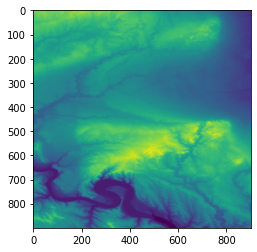

<AxesSubplot:>

In [77]:
# prove that we can read the aws files, an overview should be faster
# https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
with rio.Env(aws_session):
    with rio.open(file_s3[1], 'r') as src:
        # List of overviews from biggest to smallest
        oviews = src.overviews(1)

        # Retrieve the smallest thumbnail
        oview = oviews[1]
        thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

show(thumbnail)

In [12]:
# Create a mosaic from all the images
with rio.Env(aws_session):
    sources = [rio.open(raster) for raster in file_s3[3:6]]

In [14]:
# Merge the source files
mosaic, out_trans = merge(sources)

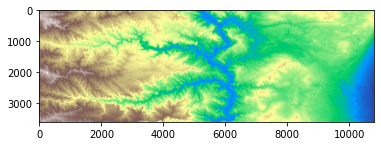

<AxesSubplot:>

In [15]:
# Mask the NoData values so it can be plotted correctly
# Not enough memory in workspace?
# TODO: reassociate spatial information
masked_mosaic = ma.masked_values(mosaic, int(sources[0].nodatavals[0]))
show(masked_mosaic, cmap = 'terrain')

In [16]:
# Now do it for just the subset in the bbox
def reproject_bbox(src, bbox, bbox_crs='epsg:4326'):
    '''
    Convert the bounding box to local coordinates of the data
    src is the raster data handler
    bbox, and bbox_crs supplied by user
    returns a rasterio window object 
    '''
    # bbox has 2 sets, row,col
    data_crs=pyproj.Proj(src.crs)
    bbox_crs=pyproj.Proj(init=bbox_crs)
    lower = pyproj.transform(bbox_crs, data_crs, bbox[0], bbox[1])
    upper = pyproj.transform(bbox_crs, data_crs, bbox[2], bbox[3])
    
    bottom, left = src.index(lower[0], lower[1])
    top, right = src.index(upper[0], upper[1])
    
    # merge back into a window
    # Remember gdal reads from the upper left corner
    width = abs(top-bottom)
    height = abs(right-left)
    local_window = rasterio.windows.Window(left, top, width, height)
    #print(local_window)
    return local_window

def read_subsets_thumb(file_s3):
    with rio.Env(aws_session):
        with rio.open(file_s3, 'r') as src:
            # List of overviews from biggest to smallest
            oviews = src.overviews(1)

            # Retrieve the smallest thumbnail
            oview = oviews[-1]
            thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
            ores = tuple(each*oview for each in src.res)
    return thumbnail

def read_subsets(file_s3, bbox):
    with rio.Env(aws_session):
        with rio.open(file_s3, 'r') as src:
            local_window = reproject_bbox(src, bbox, bbox_crs='epsg:4326')
            # query the subset with a window
            # todo: modify to allow multiband data sources
            subset = src.read(band, window=local_window)
    return subset

In [151]:
# TODO: Dilemna, need the connection to 1 raster layer to get the metadata
# But want to use this method as we can introduce partial reads
with rio.Env(aws_session):
    src = rio.open(file_s3[0])

sets = [read_subsets(raster, bbox_list) for raster in file_s3[3:6]] #this returns numpy arrays will merge work?

In [18]:
sub_mosaic, out_trans = merge(sets)

In [72]:
sub_masked_mosaic = ma.masked_values(sub_mosaic, int(src.nodatavals[0]))
show(sub_masked_mosaic, cmap = 'terrain')

### Write Results as Cloud Optimized Geotiff (Optional)
This step is included just to demonstrate writing the results to file for use in a later processing step.